<a href="https://colab.research.google.com/github/tronghieu2810/DEEP-LEARNING/blob/main/UDEMY/%5BMike_X_Cohen%5D_Deep_understanding/CNN/DUDL_CNN_codeChallengeNumChans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import copy
from sklearn.model_selection import train_test_split


# NEW! for importing data
import torchvision

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

In [2]:
# use GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Import and inspect the data

In [3]:
# Download the dataset
cdata = torchvision.datasets.EMNIST(root='emnist', split='letters', download=True)

# Transform to 4D tensor for conv layer (and transform from int8 to float)
images = cdata.data.view([124800, 1, 28, 28]).float()

# Eliminate the N/A and subtract 1 from the original
# Remove the first class category
letter_categories = cdata.classes[1:]
# Relabel labels to start at 0
labels = copy.deepcopy(cdata.targets) - 1

# Normalize the images
images /= torch.max(images)

  0%|          | 0/561753746 [00:00<?, ?it/s]

Extracting emnist/EMNIST/raw/gzip.zip to emnist/EMNIST/raw


# Create train/test groups using DataLoader

In [4]:
# Use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.1)

# Convert into PyTorch Datasets
train_data_set = TensorDataset(train_data, train_labels)
test_data_set  = TensorDataset(test_data,  test_labels)

# Translate into Dataloader objects
batch_size   = 32
train_loader = DataLoader(dataset=train_data_set, batch_size=batch_size,
                        shuffle=True, drop_last=True)
test_loader  = DataLoader(dataset=test_data_set, 
                        batch_size=test_data_set.tensors[0].shape[0])

# Create the DL model

In [5]:
def make_the_net(num_chans=(6, 6)):
    """
    CNN_EMNIST
    """
    class emnist_net(nn.Module):
        def __init__(self, num_chans):
            super().__init__()


            ######################## FEATURE MAP LAYERS ########################
            self.conv1  = nn.Conv2d(1, num_chans[0], kernel_size=3, padding=1)
            self.bnorm1 = nn.BatchNorm2d(num_features=num_chans[0])
                # (28 + 2*1 - 3)/1 + 1 = 28/2 = 14
            
            self.conv2  = nn.Conv2d(num_chans[0], num_chans[1], kernel_size=3, padding=1)
            self.bnorm2 = nn.BatchNorm2d(num_features=num_chans[1])
                # (14 + 2*1 - 3)/1 + 1 = 14/2 = 7

            ######################## LINEAR DECISION LAYERS ####################
            self.fc1 = nn.Linear(7 * 7 * num_chans[1], 50)
            self.fc2 = nn.Linear(50, 26)
        
        def forward(self, x):
            # Convolution -> Maxpool -> Batchnorm -> Relu

            x = F.max_pool2d(self.conv1(x), 2)
            x = F.leaky_relu(self.bnorm1(x))

            x = F.max_pool2d(self.conv2(x), 2)
            x = F.leaky_relu(self.bnorm2(x))

            # Reshape for linear layer
            n_units = x.shape.numel() / x.shape[0]
            x       = x.view(-1, int(n_units))

            # Linear layer
            x = F.leaky_relu(self.fc1(x))
            x = self.fc2(x)

            return x
    
    # Create the model instance
    net = emnist_net(num_chans)

    # Loss Function
    loss_func = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, loss_func, optimizer

In [6]:
# Test the model with one batch
net, loss_func, optimizer = make_the_net(num_chans=(6, 12))

X, y = iter(train_loader).next()
y_hat = net(X)

print(''), print(f'Output size: {y_hat.shape}')

loss = loss_func(y_hat, torch.squeeze(y))
print(''), print(f'Loss: {loss}')


Output size: torch.Size([32, 26])

Loss: 3.2762205600738525


(None, None)

# Create a function that trains the model

In [7]:
def train_the_model(num_chans):
    """
    CNN_ NUM_CHANS
    """
    
    num_epochs = 5

    # Create a new model
    net, loss_func, optimizer = make_the_net(num_chans)

    # Initialize
    train_loss = torch.zeros(num_epochs)
    test_loss  = torch.zeros(num_epochs)
    train_err  = torch.zeros(num_epochs)
    test_err   = torch.zeros(num_epochs)

    # Send the model to the GPU
    net.to(device)

    # Loop over epochs
    for epoch_i in range(num_epochs):
        net.train()

        # Loop over training data batches
        batch_err  = []
        batch_loss = [] 

        for X, y in train_loader:

            # Push data to GPU
            X = X.to(device)
            y = y.to(device)

            # Forward pass and loss
            y_hat = net(X)
            loss  = loss_func(y_hat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and Error from this batch
            batch_loss.append(loss.item())
            batch_err .append(torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item())

        # End of batch loop.

        # Get the average training accuracy of the batches
        train_loss[epoch_i] = np.mean(batch_loss)
        train_err [epoch_i] = 100 * np.mean(batch_err)

        # Test accuracy
        net.eval()
        X, y = next(iter(test_loader)) # Extract X, y from dataloader
        
        # Push data to GPU
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_hat = net(X)
            loss  = loss_func(y_hat, y)
            
        test_loss[epoch_i] = loss.item()
        test_err     [epoch_i] = 100 * torch.mean((torch.argmax(y_hat, axis=1) != y).float()).item()

    # End epochs

    return train_loss, test_loss, train_err, test_err, net

# Run the model and show the results!

In [8]:
train_loss, test_loss, train_err, test_err, net = train_the_model(num_chans=(3, 7))

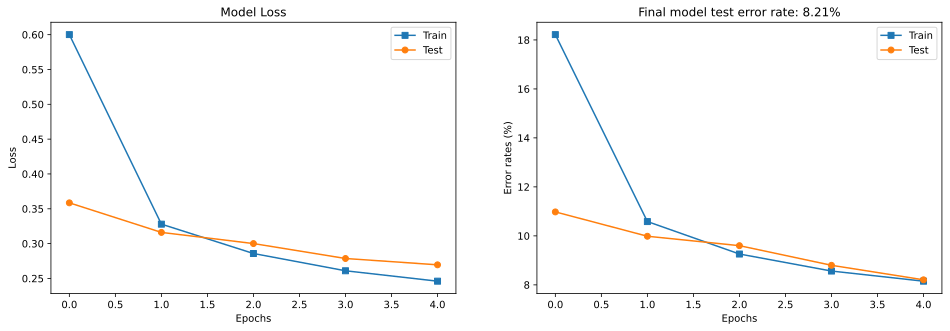

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(train_loss, 's-', label='Train')
ax[0].plot(test_loss,  'o-', label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')
ax[0].legend()

ax[1].plot(train_err, 's-', label='Train')
ax[1].plot(test_err,  'o-', label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Error rates (%)')
ax[1].set_title(f'Final model test error rate: {test_err[-1]:.2f}%')
ax[1].legend()

plt.show()

# Now for the experiment

In [10]:
import enum
conv_chans = [2, 5, 8]

# Initialize results matrix
results     = np.zeros((len(conv_chans), len(conv_chans), 2))
conv_params = np.zeros((len(conv_chans), len(conv_chans)))

for i, n_chan_i in enumerate(conv_chans):
    for j, n_chan_j in enumerate(conv_chans):
        train_loss, test_loss, train_err, test_err, net = train_the_model(num_chans=(n_chan_i, n_chan_j))

        results    [i, j, :] = train_err[-1], test_err[-1]
        conv_params[i, j]    = n_chan_i + n_chan_j # Total number of conv layer channels

        print(i, j)      

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2


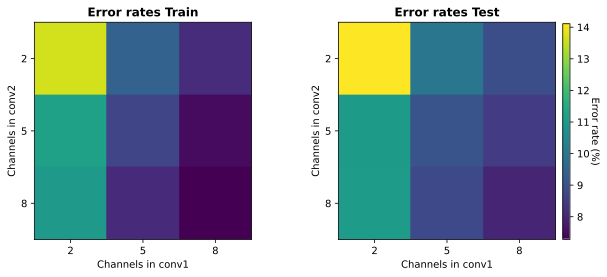

In [11]:
# Show the results matrix

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    h = ax[i].imshow(results[:, :, i], vmin=np.min(results), vmax=np.max(results))
    ax[i].set_xlabel('Channels in conv1')
    ax[i].set_ylabel('Channels in conv2')
    ax[i].set_xticks(range(j + 1))
    ax[i].set_yticks(range(j + 1))
    ax[i].set_xticklabels(conv_chans)
    ax[i].set_yticklabels(conv_chans)
    title = 'Train' if (i == 0) else 'Test'
    ax[i].set_title(f'Error rates {title}', fontweight='bold')

# Add a colorbar right of the plot
axpos = ax[1].get_position()
cax = fig.add_axes([axpos.x1+.01,axpos.y0,.01,.75])
hh = fig.colorbar(h,cax=cax)
hh.set_label('Error rate (%)',rotation=270,labelpad=10)

plt.show()

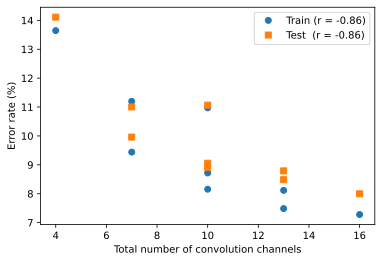

In [12]:
# Error rate as a function of the total number of conv channels
corr_train = np.corrcoef(conv_params.flatten(), results[:, :, 0].flatten())
corr_test  = np.corrcoef(conv_params.flatten(), results[:, :, 1].flatten())

plt.plot(conv_params.flatten(), results[:, :, 0].flatten(), 'o',
         label=f'Train (r = {corr_train[0, 1]:.2f})')
plt.plot(conv_params.flatten(), results[:, :, 1].flatten(), 's',
         label=f'Test  (r = {corr_test [0, 1]:.2f})')

plt.legend()
plt.xlabel('Total number of convolution channels')
plt.ylabel('Error rate (%)')
plt.show()

# Additional explorations

In [ ]:
# 1) The correlation between error rate and convolution channels looks pretty compelling. How far do you dare go?!?! Try
#    adding more channels. Does the error rate simply keep going down until it reaches zero? Or do you find a point of
#    "diminishing returns", meaning that adding more channels no longer improves performance.
# 
# 2) It seems intuitive that models with more layers take longer to train. But if there's one thing you've learned about
#    deep learning, it's that intuition doesn't always get us very far. Thus: modify the code to track the training time
#    for each model. Store the results in a separate matrix, and make an image of those results. Do they look like what
#    you had expected?
# 
# 3) Are net.train() and net.eval() necessary here? Why or why not?
# 